In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.resnet import ResNet101
from tensorflow.keras.applications import ResNet50
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import EfficientNetV2L

import random
import os
import warnings
warnings.filterwarnings('ignore')


In [ ]:
!nvidia-smi

Fri Nov 15 07:58:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
image_shape = (224,224)
batch_size = 64

In [ ]:
import os
import json
from zipfile import ZipFile
from PIL import Image

!pip install kaggle

In [ ]:
kaggle_credentails = json.load(open("kaggle.json"))

In [ ]:
!kaggle datasets download saroz014/plant-disease

Dataset URL: https://www.kaggle.com/datasets/saroz014/plant-disease
License(s): GPL-2.0
100% 1.59G/1.60G [01:26<00:00, 23.3MB/s]
100% 1.60G/1.60G [01:26<00:00, 19.8MB/s]


In [ ]:
with ZipFile("/content/plant-disease.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
train_path = r'/content/dataset/train'

test_path = r'/content/dataset/test'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale = 1/255.)

In [ ]:


# apply scaling only becouse data already augmented
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale = 1/255.)

# load training data
print("Training Images:")
train_data = train_datagen.flow_from_directory(train_path,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training')

# load validation data (20% of training data)
print("Validating Images:")
valid_data = train_datagen.flow_from_directory(train_path,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation')

# load test data (consider validation data as test data)
print('Test Images:')
test_data = test_datagen.flow_from_directory(test_path,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False)

Training Images:
Found 34781 images belonging to 38 classes.
Validating Images:
Found 8675 images belonging to 38 classes.
Test Images:
Found 10849 images belonging to 38 classes.


In [ ]:
images, labels = next(iter(train_data))
print(f'shape of image is : {images[0].shape}')
print(f'label  \n{labels[0]}')


shape of image is : (224, 224, 3)
label  
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
diseases = os.listdir(train_path)
print(diseases)

['Peach___healthy', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Grape___healthy', 'Blueberry___healthy', 'Apple___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___Common_rust_', 'Potato___Early_blight', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Grape___Black_rot', 'Apple___Apple_scab', 'Soybean___healthy', 'Pepper,_bell___Bacterial_spot', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Tomato___Late_blight', 'Strawberry___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Cherry_(including_sour)___healthy', 'Tomato___Bacterial_spot', 'Grape___Esca_(Black_Measles)', 'Tomato___Early_blight', 'Orange___Haunglongbing_(Citrus_greening)', 'Corn_(maize)___healthy', 'Pepper,_bell___healthy', 'Tomato___Leaf_Mold', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato___Septoria_leaf_spot', 'Squash___Powdery_mildew', 'Peach___Bacter

In [ ]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
print(f'number of different plants is :{len(plants)}')
print(plants)

number of different plants is :14
['Peach', 'Tomato', 'Grape', 'Blueberry', 'Apple', 'Corn_(maize)', 'Potato', 'Strawberry', 'Soybean', 'Pepper,_bell', 'Raspberry', 'Cherry_(including_sour)', 'Orange', 'Squash']


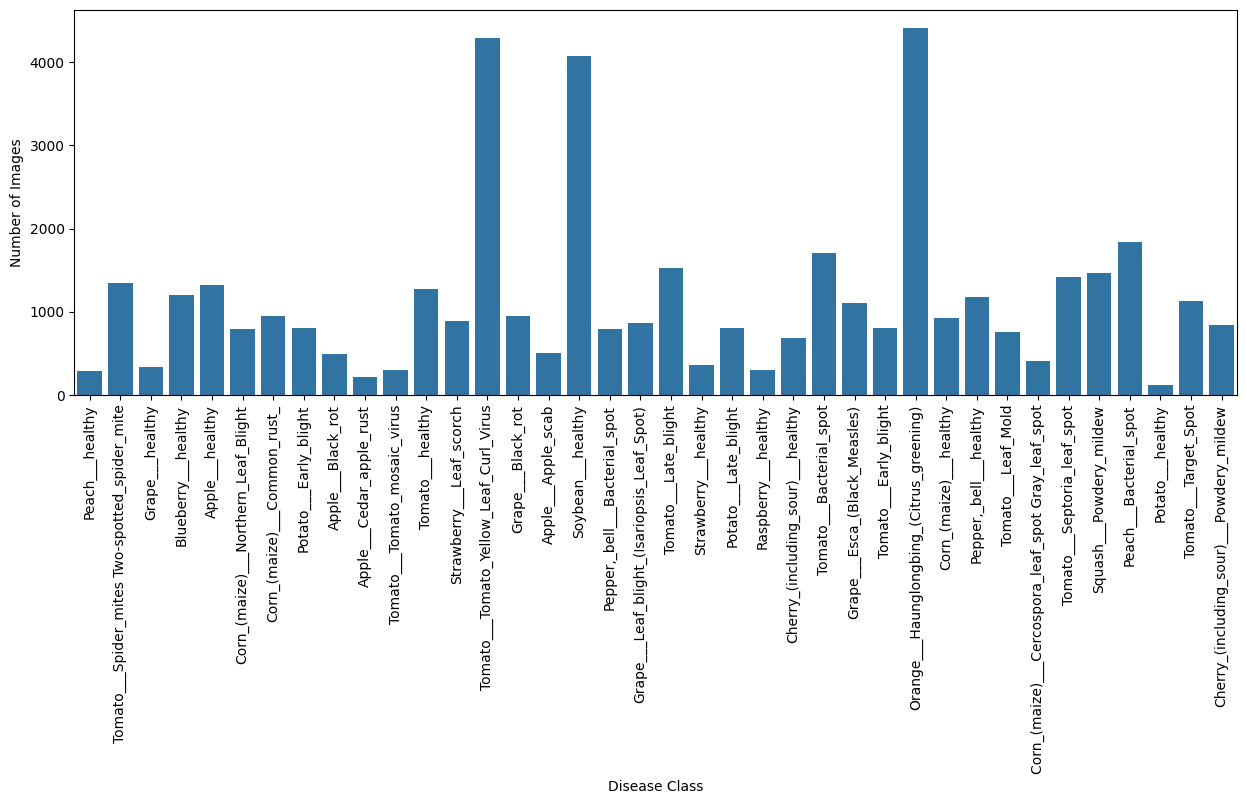

In [ ]:
dic = {}
for Class in diseases:
    dic[Class] = len(os.listdir(train_path + '/' + Class))

df = pd.DataFrame(list(dic.items()), columns=["Disease Class", "Number of Images"])

# df = df.sort_values(by="Number of Images", ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(data=df ,x='Disease Class' ,y= 'Number of Images' )
plt.xticks(rotation=90)
plt.show()

In [ ]:
import random
# select a specific batch
images, labels = next(iter(train_data))

# select 16 image by random
indices = random.sample(range(len(images)), 16)
selected_images = images[indices]
selected_labels = labels[indices]

class_names = list(train_data.class_indices.keys())

# plotting
plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(selected_images[i])
    plt.title(class_names[np.argmax(selected_labels[i])])
    plt.axis("off")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    # accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # loss curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


In [ ]:
def predict_labels_and_display(model_path, test_dir='/content/dataset/test', image_size=(224, 224)):
    # load the best model
    best_model = load_model(model_path)

    true_labels = []
    predicted_labels = []
    images = []

    for subdir in os.listdir(test_dir):  # Iterate through subdirectories
        subdir_path = os.path.join(test_dir, subdir)
        if os.path.isdir(subdir_path):  # Check if it's a directory
            for filename in os.listdir(subdir_path):

              img_path = os.path.join(subdir_path, filename)
              img = load_img(img_path, target_size=image_size)
              img_array = img_to_array(img)
              img_array = img_array / 255.0  # Rescale
              img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

                # Make prediction
              prediction = best_model.predict(img_array)
              predicted_label = np.argmax(prediction)

                # Store results
              true_labels.append(subdir)  # Assuming subdir name is the true label
              predicted_labels.append(predicted_label)
              images.append(img)

    # Display results (example using matplotlib)
    plt.figure(figsize=(12, 12))
    for i in range(min(len(images), 16)):  # Display up to 16 images
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()



In [ ]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation = 'elu',input_shape=(224,224,3), kernel_initializer=GlorotNormal()))
model.add(Conv2D(32, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(64, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(128, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

# model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='elu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(128, activation='elu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='elu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(38, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 108, 108, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 106, 106, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 51, 51, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 49, 49, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 365,446 (1.39 MB)

 Trainable params: 364,550 (1.39 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
model_checkpoint = ModelCheckpoint('cnn_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=10,
                    batch_size=64,
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.3866 - loss: 2.2930
Epoch 1: val_accuracy improved from -inf to 0.69014, saving model to cnn_model.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 203s 317ms/step - accuracy: 0.3868 - loss: 2.2920 - val_accuracy: 0.6901 - val_loss: 1.0266
Epoch 2/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.7077 - loss: 0.9909
Epoch 2: val_accuracy improved from 0.69014 to 0.80830, saving model to cnn_model.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 156s 285ms/step - accuracy: 0.7078 - loss: 0.9907 - val_accuracy: 0.8083 - val_loss: 0.6116
Epoch 3/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.8048 - loss: 0.6322
Epoch 3: val_accuracy improved from 0.80830 to 0.84035, saving model to cnn_model.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 157s 287ms/step - accuracy: 0.8049 - loss: 0.6321 - val_accuracy: 0.8403 - val_loss: 0.4990
Epoch 4/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.8627 - loss: 0.4403
Epoch 4: val_accuracy di

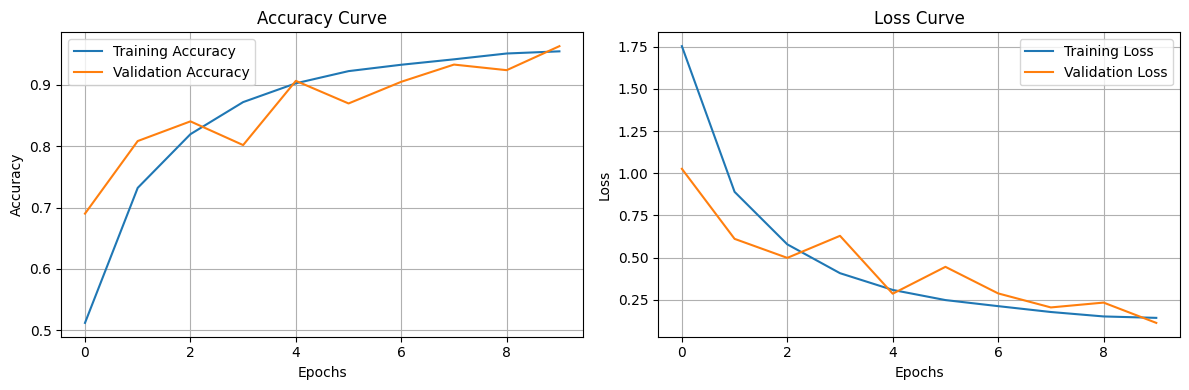

In [ ]:
plot_learning_curves(history)

In [ ]:
best_model = load_model('cnn_model.keras')

test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

170/170 ━━━━━━━━━━━━━━━━━━━━ 31s 174ms/step - accuracy: 0.9600 - loss: 0.1122
Test Loss: 0.1136
Test Accuracy: 0.9604


In [29]:
predictions = best_model.predict(test_data)

# Get the predicted class indices
y_pred = np.argmax(predictions, axis=1)[0]

# Get the true class indices
y_true = test_data.classes

170/170 ━━━━━━━━━━━━━━━━━━━━ 26s 147ms/step


In [30]:
from sklearn.metrics import classification_report
class_labels = list(test_data.class_indices.keys())

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.95      0.97       126
                                 Apple___Black_rot       0.98      0.98      0.98       124
                          Apple___Cedar_apple_rust       0.92      1.00      0.96        55
                                   Apple___healthy       0.93      0.97      0.95       329
                               Blueberry___healthy       1.00      0.98      0.99       300
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       210
                 Cherry_(including_sour)___healthy       0.99      0.96      0.98       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.59      0.92      0.72       102
                       Corn_(maize)___Common_rust_       1.00      0.99      1.00       238
               Corn_(maize)___Northern_Leaf_Blight       0.94      0.66      0.

<Figure size 3000x3000 with 0 Axes>

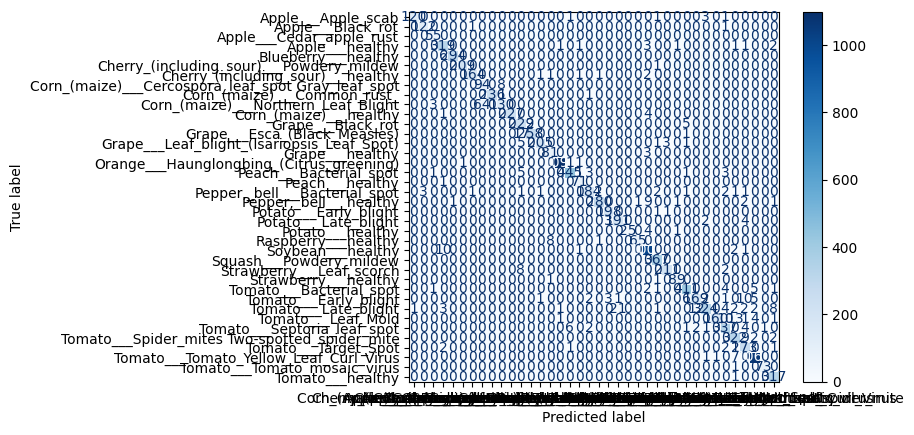

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 30))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()


**Densenet Model**


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


densenet_base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
densenet_base_model.trainable = False

# Build model architecture
inputs = layers.Input(shape=(224, 224, 3))
x = densenet_base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(38, activation='softmax')(x)


densenet_model = models.Model(inputs, outputs)

# Compile the model
densenet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

densenet_model.summary()

In [35]:
densenet_base_model.trainable = True
for layer in densenet_base_model.layers[:-20]:
    layer.trainable = False

# Recompile before fine-tuning
densenet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

In [38]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('densenet_model.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]


history = densenet_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=25,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/25
544/544 ━━━━━━━━━━━━━━━━━━━━ 149s 271ms/step - accuracy: 0.9956 - loss: 0.0139 - precision: 0.9961 - recall: 0.9952 - val_accuracy: 0.9908 - val_loss: 0.0328 - val_precision: 0.9917 - val_recall: 0.9901 - learning_rate: 1.0000e-05
Epoch 2/25
544/544 ━━━━━━━━━━━━━━━━━━━━ 177s 226ms/step - accuracy: 0.9971 - loss: 0.0110 - precision: 0.9974 - recall: 0.9966 - val_accuracy: 0.9905 - val_loss: 0.0324 - val_precision: 0.9917 - val_recall: 0.9899 - learning_rate: 1.0000e-05
Epoch 3/25
544/544 ━━━━━━━━━━━━━━━━━━━━ 119s 217ms/step - accuracy: 0.9971 - loss: 0.0104 - precision: 0.9974 - recall: 0.9966 - val_accuracy: 0.9910 - val_loss: 0.0325 - val_precision: 0.9921 - val_recall: 0.9904 - learning_rate: 1.0000e-05
Epoch 4/25
544/544 ━━━━━━━━━━━━━━━━━━━━ 144s 220ms/step - accuracy: 0.9971 - loss: 0.0114 - precision: 0.9974 - recall: 0.9962 - val_accuracy: 0.9910 - val_loss: 0.0322 - val_precision: 0.9921 - val_recall: 0.9903 - learning_rate: 1.0000e-05
Epoch 5/25
544/544 ━━━━━━━━━━━━━

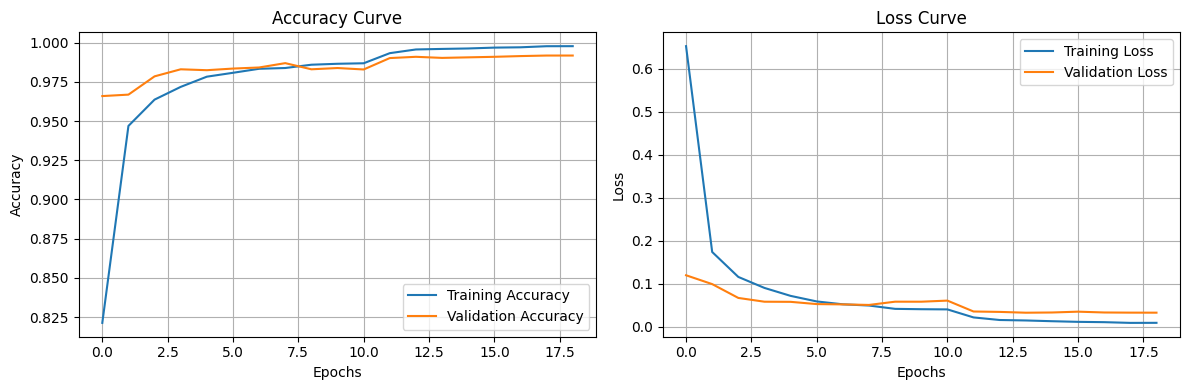

In [37]:
plot_learning_curves(history)

In [42]:
densenet_model = load_model('densenet_model.keras')

dense_test_loss, dense_test_accuracy, dense_test_precision, dense_test_recall= densenet_model.evaluate(test_data)
print(f"Test Loss: {dense_test_loss:.4f}")
print(f"Test Accuracy: {dense_test_accuracy:.4f}")
print(f"Test Precision: {dense_test_precision:.4f}")
print(f"Test Recall: {dense_test_recall:.4f}")

170/170 ━━━━━━━━━━━━━━━━━━━━ 43s 189ms/step - accuracy: 0.9938 - loss: 0.0251 - precision: 0.9941 - recall: 0.9937
Test Loss: 0.0286
Test Accuracy: 0.9918
Test Precision: 0.9926
Test Recall: 0.9914


In [47]:
dense_predictions = densenet_model.predict(test_data)

# Get the predicted class indices
y_pred_dense = np.argmax(dense_predictions, axis=1)

# Get the true class indices
y_true = test_data.classes

170/170 ━━━━━━━━━━━━━━━━━━━━ 31s 185ms/step


In [48]:
report = classification_report(y_true, y_pred_dense, target_names=class_labels)
print(report)


                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      1.00      0.99       126
                                 Apple___Black_rot       1.00      0.99      1.00       124
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        55
                                   Apple___healthy       1.00      1.00      1.00       329
                               Blueberry___healthy       1.00      1.00      1.00       300
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       210
                 Cherry_(including_sour)___healthy       1.00      0.99      0.99       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.90      0.93       102
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       238
               Corn_(maize)___Northern_Leaf_Blight       0.95      0.98      0.

<Figure size 1200x3000 with 0 Axes>

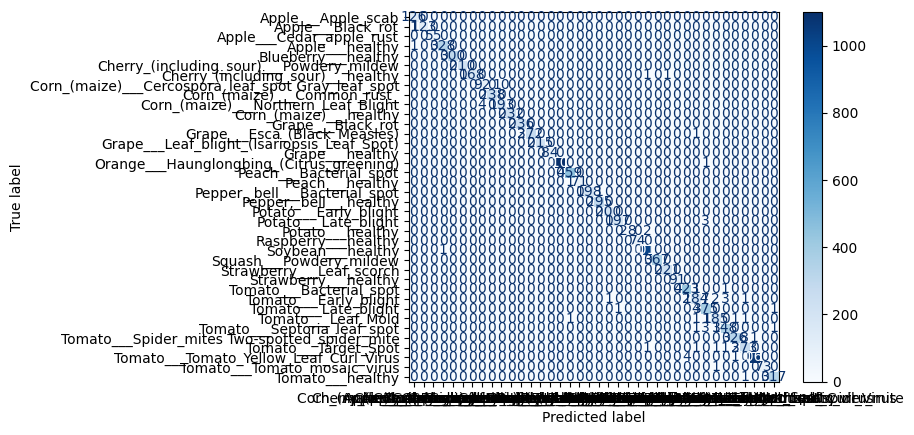

In [49]:
cm = confusion_matrix(y_true, y_pred_dense)

# Plot confusion matrix
plt.figure(figsize=(12, 30))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()